In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.realpath('../'))

In [2]:
import LDAQ

#### Creation of simulated signals:

(0.0, 500.0)

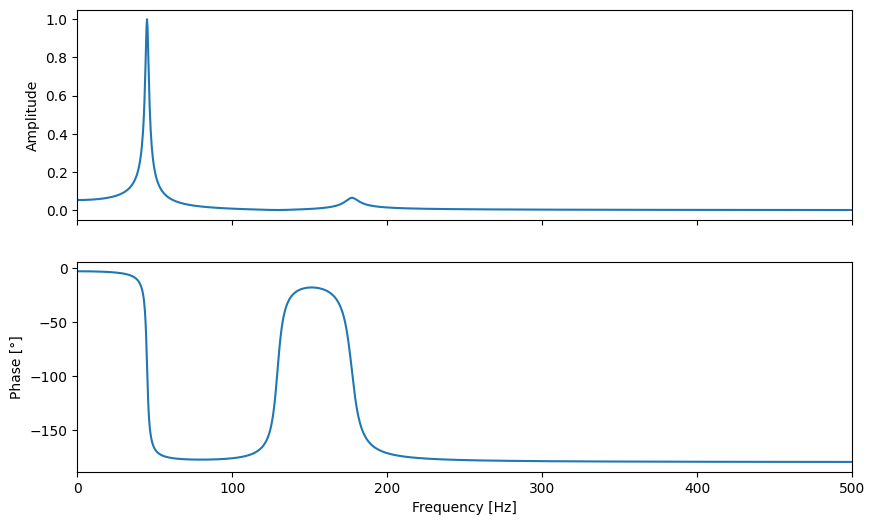

In [3]:
fs = 10000.
t = np.arange(fs*3)/fs          # 3 seconds of data
x = np.random.rand(t.shape[0])  # random excitation

# simulated frequency response function of 2 DOF second order system:
freq = np.fft.rfftfreq(x.shape[0], 1/fs)
omega = 2*np.pi*freq
omega_01, omega_02 = 2*np.pi*45, 2*np.pi*177 # natural frequencies
ni = 0.05 # damping ratio
H = 1/(-omega**2 + omega_01**2 + 1j * ni * omega_01**2) + 1/(-omega**2 + omega_02**2 + 1j * ni * omega_02**2)  # 2 DOF transfer function
H = H/np.max(np.abs(H)) # normalize

# simulated response:
X = np.fft.rfft(x)
Y = X*H
y = np.fft.irfft(Y, n=x.shape[0]) # response time signal
y = y + 0.05*(y.max()-y.min())*np.random.rand(y.shape[0]) # add noise

# plot frequency repsonse function:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(freq, np.abs(H))
axs[1].plot(freq, np.angle(H)*180/np.pi)
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Phase [°]')
axs[-1].set_xlabel('Frequency [Hz]')
axs[-1].set_xlim([0, 500])

#### Creation of simulated acquisition source:

In [4]:
# Create simulated data acquisition sources:
acq = LDAQ.simulator.SimulatedAcquisition(acquisition_name='sim')

In [5]:
# define simulated data using simulated excitation 'x' and repsonse 'y':
simulated_data = np.array([x, y]).T
acq.set_simulated_data(simulated_data, channel_names=["excitation", "response"], sample_rate=fs, args=(84, 120))

# NOTE: in real application, the 'acq' object can be replaced with any other acquisition object and code to follow will work the same

In [6]:
# function for calculating coherence:
from scipy.signal import coherence
def fun_coherence(self_vis, channel_data):   
    """function applied to channel vs. channel. subplot to calculate coherence.
    
    Args:
        self_vis (class): visualization class object
        channel_data (array): 2D numpy array with (samples, channel) shape.
        
    Returns:
        2D numpy array: np.array([freq, coherence]).T
    """
    # estimate FRF:
    x, y = channel_data.T
    fs   = self_vis.acquisition.sample_rate   
    freq, coh = coherence(x, y, fs, nperseg=fs)
    
    return np.array([freq, coh]).T

def fun_scale(self_vis, channel):
    """This function will be applied to each line individually.

    Args:
        self_vis (class): visualization class object
        channel (array): 1D numpy array with shape (samples, ).
    """
    return channel*1000

# Create visualization object: 
vis = LDAQ.Visualization(sequential_plot_updates=False)
vis.add_lines((0,0), source='sim', channels=["excitation"], refresh_rate=50)
vis.add_lines((0,1), source='sim', channels=["response"],   refresh_rate=50, function=fun_scale)
vis.add_lines((1,0), source='sim', channels=[("excitation", "response")], function="frf_amp",   refresh_rate=2000, nth=1) # nth=1 means that we force plotting each data point
vis.add_lines((2,0), source='sim', channels=[("excitation", "response")], function="frf_phase", refresh_rate=2000, nth=1)
vis.add_lines((3,0), source='sim', channels=[("excitation", "response")], function="coh",       refresh_rate=2000, nth=1)

vis.config_subplot((0,0), t_span=0.2, title="Excitation")
vis.config_subplot((0,1), t_span=0.2, title="Response * 1000")
vis.config_subplot((1,0), t_span=5, xlim=(0, 300), axis_style="semilogy", colspan=2, title="FRF Amplitude")
vis.config_subplot((2,0), t_span=5, xlim=(0, 300), ylim=(-181, 181)     , colspan=2, title="FRF Phase")
vis.config_subplot((3,0), t_span=5, xlim=(0, 300), ylim=(0, 1)          , colspan=2, title="Coherence")

In [7]:
# create core object and run:
ldaq = LDAQ.Core(acquisitions=[acq], visualization=vis)
ldaq.run(3.0)